In [1]:
import simpy
import networkx as nx
import datetime

import itertools
import requests
import pickle
import io

import pandas as pd
import geopandas as gpd

import simpy

import itertools

import matplotlib.pyplot as plt

import pint
ureg = pint.UnitRegistry()

In [2]:
url = 'https://zenodo.org/records/6673604/files/network_digital_twin_v0.3.pickle?download=1'
resp = requests.get(url)

In [3]:
graph = pickle.load(io.BytesIO(resp.content))
trips_gdf = gpd.read_parquet('week_38_routes.parquet')

In [4]:
nodes = {
    "Nijmegen": "22638188",
    "Duisburg": "FN96",
    "Rotterdam": "18008346",
}

145699.13091711738

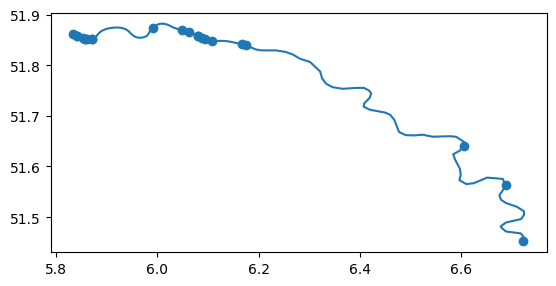

In [5]:
def get_route_gdfs(a, b):
    route = nx.shortest_path(graph, source=a, target=b, weight="length_m")


    nodes = []
    for n in route:
        node = graph.nodes[n]
        nodes.append(node)
    
    node_df = pd.DataFrame(nodes)
    geometry = gpd.GeoSeries.from_wkt(node_df['Wkt'])
    node_gdf = gpd.GeoDataFrame(node_df, geometry=geometry)

    edges = []
    for a, b in zip(route[:-1], route[1:]):
        edge = graph.edges[(a, b)]
        edges.append(edge)

    edge_df = pd.DataFrame(edges)
    geometry = gpd.GeoSeries.from_wkt(edge_df['Wkt'])
    edge_gdf = gpd.GeoDataFrame(edge_df, geometry=geometry)
    
    
    result = {"edge": edge_gdf, "node": node_gdf}
    return result


route_gdfs = get_route_gdfs(nodes['Nijmegen'], nodes['Duisburg'])
edge_gdf = route_gdfs["edge"]
node_gdf = route_gdfs["node"]

fig, ax = plt.subplots()

edge_gdf.plot(ax=ax)
node_gdf.plot(ax=ax)
    
edge_gdf["length_m"].sum()

In [6]:
source_gdf = trips_gdf.groupby(["source"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
target_gdf = trips_gdf.groupby(["target"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
trips_gdf_agg = trips_gdf.groupby(["route"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
trips_gdf_agg

,sum,count
route,,
Duisburg-Nijmegen,537.0,7
Duisburg-Rotterdam,18583.0,794
Nijmegen-Duisburg,473.0,7
Nijmegen-Rotterdam,5274.0,56
Rotterdam-Duisburg,23334.0,810
Rotterdam-Nijmegen,6413.0,64


In [7]:
max_capacity = trips_gdf['v30_4_Containers_TEU_S'].sum()

In [8]:
env = simpy.Environment()

In [9]:
def create_container(row, env, fill):
    if fill:
        init = row['sum']
    else:
        init = 0
    
    container = simpy.Container(env=env, capacity=max_capacity, init=init)
    return container
    
source_gdf["container"] = source_gdf.apply(create_container, env=env, fill=True, axis=1)
target_gdf["container"] = target_gdf.apply(create_container, env=env, fill=False, axis=1)
trips_gdf_agg["container"] = trips_gdf_agg.apply(create_container, env=env, fill=True, axis=1)
trips_gdf_agg

,sum,count,container
route,,,
Duisburg-Nijmegen,537.0,7,<simpy.resources.container.Container object at...
Duisburg-Rotterdam,18583.0,794,<simpy.resources.container.Container object at...
Nijmegen-Duisburg,473.0,7,<simpy.resources.container.Container object at...
Nijmegen-Rotterdam,5274.0,56,<simpy.resources.container.Container object at...
Rotterdam-Duisburg,23334.0,810,<simpy.resources.container.Container object at...
Rotterdam-Nijmegen,6413.0,64,<simpy.resources.container.Container object at...


In [10]:
trips_gdf_rotterdam_source = trips_gdf[trips_gdf['source'] == 'Rotterdam']
trip = trips_gdf_rotterdam_source.iloc[0]

In [11]:
trip = {
    "source": "Rotterdam",
    "target": "Duisburg",
    "target_hub": "Nijmegen",
    "ship_cargo": simpy.Container(env, capacity=200, init=0)
}

In [12]:
import contextlib
COUNT = itertools.count()

class LogDecorator(contextlib.ContextDecorator):
    logbook = []
    def __init__(self, env, message='', **kwargs):
        """initialize the logbook"""
        super().__init__()
        self.env = env

        
        self.message = message
        self.kwargs = kwargs

        self.activity_id = next(COUNT)

    def log_entry(
        self,
        message=None,
        timestamp=None,
        value=None,
        geometry=None,
        activity_id=None,
        state=None,
        **kwargs
    ):
        timestamp = env.now
        entry = {
            "Message": message,
            "Timestamp": datetime.datetime.utcfromtimestamp(timestamp),
            "Value": value,
            "geometry": geometry,
            "ActivityID": activity_id or next(COUNT),
            "State": state,
            "Meta": kwargs,
        }
        self.logbook.append(entry)

    def __enter__(self):
        """log a start message on entrance"""
        kwargs = {}
        kwargs.update(self.kwargs)
        self.log_entry(
            message=self.message,
            timestamp=self.env.now,
            activity_id=self.activity_id,
            state="START"
        )
        return self

    def __exit__(self, *exc):
        """log a stop message on exit"""
        self.log_entry(
            message=self.message,
            timestamp=self.env.now,
            activity_id=self.activity_id,
            state="STOP"
        )
        return False



In [13]:
def load(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    ship_container = trip["ship_cargo"]
    if trip["target_hub"] != trip["target"]:
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]
    
    loading_rate = 20
    with (
        source_container.get(ship_container.capacity) as get_req, 
        ship_container.put(ship_container.capacity) as put_req,
    ):
        with LogDecorator(env, message="get container"):
            yield get_req
        yield put_req
        yield env.timeout(ship_container.capacity * loading_rate)
        print("Cargo loaded in ship", env.now)


def unload(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    ship_container = trip["ship_cargo"]
    if trip["target_hub"] != trip["target"]:
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]
    
    loading_rate = 20
    with (
        ship_container.get(ship_container.capacity) as get_req,
        target_container.put(ship_container.capacity) as put_req, 
    ):
        print("Loading cargo from ship", env.now)
        yield get_req
        print("Ship cargo available")
        yield put_req
        print("Target cargo available")
        yield env.timeout(ship_container.capacity * loading_rate)
        print("Cargo loaded in target", env.now)


def move(trip, a, b):
    route_gdfs = get_route_gdfs(a, b)
    edge_gdf = route_gdfs["edge"]
    node_gdf = route_gdfs["node"]

    route_length_m = edge_gdf["length_m"].sum()
    velocity = 4
    duration = route_length_m / velocity # m / m/s = m * s / m = s
    print("Moving from", a, env.now)
    yield env.timeout(duration)
    print("Arrived at", b, env.now)


def cycle(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    while source_container.level:
        yield from load(trip)
        a = nodes[trip["source"]]
        b = nodes[trip["target_hub"]]
        yield from move(trip, a, b)
        
        yield from unload(trip)
        yield from move(trip, b, a)

env.process(cycle(trip))

env.run()

Cargo loaded in ship 4000
Moving from 18008346 4000
Arrived at 22638188 59929.68754816057
Loading cargo from ship 59929.68754816057
Ship cargo available
Target cargo available
Cargo loaded in target 63929.68754816057
Moving from 22638188 63929.68754816057
Arrived at 18008346 119859.37509632114
Cargo loaded in ship 123859.37509632114
Moving from 18008346 123859.37509632114
Arrived at 22638188 179789.06264448172
Loading cargo from ship 179789.06264448172
Ship cargo available
Target cargo available
Cargo loaded in target 183789.06264448172
Moving from 22638188 183789.06264448172
Arrived at 18008346 239718.75019264227
Cargo loaded in ship 243718.75019264227
Moving from 18008346 243718.75019264227
Arrived at 22638188 299648.4377408028
Loading cargo from ship 299648.4377408028
Ship cargo available
Target cargo available
Cargo loaded in target 303648.4377408028
Moving from 22638188 303648.4377408028
Arrived at 18008346 359578.1252889634
Cargo loaded in ship 363578.1252889634
Moving from 18008

In [15]:
log_df = pd.DataFrame(LogDecorator.logbook)

In [16]:
 log_df.pivot(index="ActivityID", columns="State")

Message                                 Timestamp  \
State               START           STOP                      START   
ActivityID                                                            
1           get container            NaN 1970-01-01 00:00:00.000000   
2                     NaN  get container                        NaT   
3           get container  get container 1970-01-02 09:17:39.375096   
4           get container  get container 1970-01-03 18:35:18.750193   
5           get container  get container 1970-01-05 03:52:58.125289   
...                   ...            ...                        ...   
114         get container  get container 1970-06-05 08:57:30.010788   
115         get container  get container 1970-06-06 18:15:09.385884   
116         get container  get container 1970-06-08 03:32:48.760981   
117         get container  get container 1970-06-09 12:50:28.136077   
118         get container            NaN 1970-06-10 22:08:07.511173   

                                      Value       geometry        Meta       
State                            STOP START  STOP    START  STOP START STOP  
ActivityID                                                                   
1                                 NaT  None   NaN     None   NaN    {}  NaN  
2          1970-01-01 00:00:00.000000   NaN  None      NaN  None   NaN   {}  
3          1970-01-02 09:17:39.375096  None  None     None  None    {}   {}  
4          1970-01-03 18:35:18.750193  None  None     None  None    {}   {}  
5          1970-01-05 03:52:58.125289  None  None     None  None    {}   {}  
...                               ...   ...   ...      ...   ...   ...  ...  
114        1970-06-05 08:57:30.010788  None  None     None  None    {}   {}  
115        1970-06-06 18:15:09.385884  None  None     None  None    {}   {}  
116        1970-06-08 03:32:48.760981  None  None     None  None    {}   {}  
117        1970-06-09 12:50:28.136077  None  None     None  None    {}   {}  
118                               NaT  None   NaN     None   NaN    {}  NaN  

[118 rows x 10 columns]